# LanGraph Intro

https://ywctech.net/ml-ai/langchain-langgraph-agent-part1/

LangGraph 是一個用於建立複雜、狀態化的多AI代理系統的革命性框架，特別適用於與大型語言模型 (LLM) 合作。LangGraph 以圖形結構為基礎，將每個 AI 代理視為節點，而代理之間的資訊傳遞則以邊來呈現。它提供狀態管理功能，讓代理能夠在執行任務時更新自身的狀態，並保持上下文連貫性。此外，LangGraph 還具備協調能力，確保代理按正確順序執行任務，並有效地交換資訊。透過這些特性，LangGraph 簡化了開發流程，讓開發者可以更專注於應用的高階邏輯。LangGraph 適用於各種場景，例如智能客服系統、工作流程自動化、多代理協作系統、智能推薦系統以及個人化學習平台等。文章詳細介紹了 LangGraph 的核心概念、應用場景、使用方法以及優缺點，旨在讓讀者了解 LangGraph 的強大功能，並鼓勵他們開始使用這個工具來開發更智能的 AI 應用。



圖結構（Graph Structure）：AI 應用的骨架
LangGraph 採用有向圖（Directed Graph）來描述應用程式結構。想像將你的應用程式描述成一張有向圖，LangGraph 世界中，將每一個節點(Node) 都代表一個代理人，邊(edge) 則是代理人之間傳遞資訊的通道。利用這種清晰的結構且可管理的工作流程，每個代理人可以執行特定任務之外也能將資訊傳遞給其他代理。

- 節點（Node）：代表各個智能代理
- 邊（Edge）：代表代理之間的信息傳遞通道

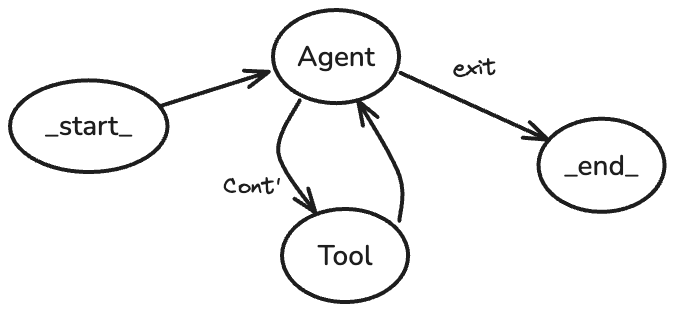

狀態管理（State Management）
LangGraph 的狀態管理功能就像是給 AI 安裝了一個超級記憶體。當 AI 代理執行任務時，它們可以即時更新自己的狀態，確保系統能夠維持上下文的連貫性，並對輸入做出最恰當的回應。這項功能讓開發者能夠在多輪對話中追蹤和保留關鍵資訊，大大提升了 AI 應用的智慧程度和使用體驗。

LangGraph 的動態狀態更新機制確保系統能夠：

- 維護上下文
- 對輸入做出適當回應
- 在多次交互中追踪和保留關鍵信息

協調（Coordination）
LangGraph 的協調功能就像是一位精明的指揮家，確保每個 AI 代理都能在正確的時機演奏出最美妙的音符。通過精確管理資料流和操作順序，LangGraph 讓開發者能夠專注於設計應用的高階邏輯，而無需陷入繁瑣的協調細節中。

LangGraph 的協調功能確保：

- 代理按正確順序執行任務
- 信息在代理間無縫交換
- 開發者可專注於應用程序的高階邏輯


💡 亮點：LangGraph 的協調功能極大地簡化了複雜多代理系統的開發流程，使得構建高度智能化的應用變得前所未有的簡單。

教學：

https://langchain-ai.github.io/langgraph/tutorials/introduction/#requirements

## Concept

# Conversational RAG

In [9]:
from typing import Sequence

import bs4
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict

import os
from dotenv import load_dotenv

load_dotenv("/Users/wenye/ML&AI Tutor/.env.local")

OPENAI_KEY = os.getenv("OPENAI_KEY")

llm = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAI_KEY)
OPENAI_EMBEDDING = OpenAIEmbeddings(api_key=OPENAI_KEY)


### Construct retriever ###
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = InMemoryVectorStore.from_documents(
    documents=splits, embedding=OPENAI_EMBEDDING
)
retriever = vectorstore.as_retriever()


### Contextualize question ###
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)


### Answer question ###
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)
qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)


### Statefully manage chat history ###
class State(TypedDict):
    input: str
    chat_history: Annotated[Sequence[BaseMessage], add_messages]
    context: str
    answer: str


def call_model(state: State):
    response = rag_chain.invoke(state)
    return {
        "chat_history": [
            HumanMessage(state["input"]),
            AIMessage(response["answer"]),
        ],
        "context": response["context"],
        "answer": response["answer"],
    }


workflow = StateGraph(state_schema=State)
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [10]:
config = {"configurable": {"thread_id": "abc123"}}

result = app.invoke(
    {"input": "What is Task Decomposition?"},
    config=config,
)
print(result["answer"])

Task decomposition is the process of breaking down a complicated task into smaller, more manageable steps. Techniques like Chain of Thought (CoT) and Tree of Thoughts (ToT) facilitate this by guiding models to think step by step and explore multiple reasoning possibilities, respectively. This approach enhances understanding and execution of complex tasks.


In [11]:
result = app.invoke(
    {"input": "What is one way of doing it?"},
    config=config,
)
print(result["answer"])

One way to perform task decomposition is by using simple prompting, such as asking "Steps for XYZ.\n1." This method directs the model to outline the necessary steps to achieve a specific goal. It can also involve task-specific instructions tailored to the nature of the task, like "Write a story outline." for writing a novel.


In [12]:
result["context"][0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}

In [13]:
chat_history = app.get_state(config).values["chat_history"]
for message in chat_history:
    message.pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================

Task decomposition is the process of breaking down a complicated task into smaller, more manageable steps. Techniques like Chain of Thought (CoT) and Tree of Thoughts (ToT) facilitate this by guiding models to think step by step and explore multiple reasoning possibilities, respectively. This approach enhances understanding and execution of complex tasks.
================================ Human Message =================================

What is one way of doing it?
================================== Ai Message ==================================

One way to perform task decomposition is by using simple prompting, such as asking "Steps for XYZ.\n1." This method directs the model to outline the necessary steps to achieve a specific goal. It can also involve task-specific instructions tailored to the n

# Agent

In [26]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [27]:
from dotenv import load_dotenv

load_dotenv("/Users/wenye/ML&AI Tutor/.env.local")

OPENAI_KEY = os.getenv("OPENAI_KEY")

from langchain_openai import ChatOpenAI, OpenAIEmbeddings

llm = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAI_KEY)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node(node="chatbot", action=chatbot)

In [28]:
# Next, add an entry point.
# This tells our graph where to start its work each time we run it.
graph_builder.add_edge(start_key=START, end_key="chatbot")

In [29]:
# Similarly, set a finish point.
# This instructs the graph "any time this node is run, you can exit."
graph_builder.add_edge(start_key="chatbot", end_key=END)

In [30]:
graph = graph_builder.compile()

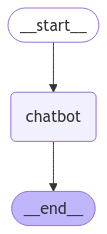

In [31]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [32]:
# Now let's run the chatbot!
# Tip: You can exit the chat loop at any time by typing "quit", "exit", or "q".


def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 你是問自己身份的人，可能是一位有思考、有情感的個體。如果你有具體的問題或想要討論的主題，請告訴我，我會很高興幫助你！
Assistant: 你好！有什麼我可以幫忙的嗎？
Goodbye!


### Using Tool in Agent

Next, define the tool:


先從最後的圖看回來。

In [45]:
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv

load_dotenv("/Users/wenye/ML&AI Tutor/.env.local")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making'},
 {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state"}]

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAI_KEY)

# Modification: tell the LLM which tools it can call
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [47]:
# 再繼續之前，先看一個進階的 python 語法

inputs = {"messages": ["Hello", "World"]}

if messages := inputs.get("messages", []):
    print(f"Found messages: {messages}")
else:
    print("No messages found.")

inputs = {"aaa": ["Hello", "World"]}

if messages := inputs.get("messages", []):
    print(f"Found messages: {messages}")
else:
    print("No messages found.")


# 上面的寫法等同於
inputs = {"messages": ["Hello", "World"]}

messages = inputs.get("messages", [])
if messages:
    print(f"Found messages: {messages}")
else:
    print("No messages found.")

Found messages: ['Hello', 'World']
No messages found.
Found messages: ['Hello', 'World']


In [ ]:
import json

from langchain_core.messages import ToolMessage

# 以下是一個原始的寫法
# 之後會用 ToolNode 來取代


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):  # 這裡是新的寫法
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


# 這裡製作了一個將 message 輸入到 tools 中的 node
# 當今天 agent 需要使用 tools 時，只需要將 tool 加入到 tools 參數中即可

tool = TavilySearchResults(max_results=2)
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [49]:
# With the tool node added, we can define the conditional_edges.

# Recall that edges route the control flow from one node to the next.
# Conditional edges usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph state and return a string or list of strings indicating which node(s) to call next.

# Below, call define a router function called route_tools,
# that checks for tool_calls in the chatbot's output. Provide this function to the graph by calling add_conditional_edges, which tells the graph that whenever the chatbot node completes to check this function to see where to go next.

# The condition will route to tools if tool calls are present and END if not.

# Later, we will replace this with the prebuilt tools_condition to be more concise,
# but implementing it ourselves first makes things more clear.


from typing import Literal


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    source="chatbot",  # The node to check the condition on
    path=route_tools,  # The function to check the condition
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    path_map={
        "tools": "tools",
        END: END,
    },  # The mapping of the condition's outputs to nodes
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph = graph_builder.compile()

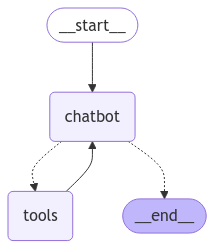

In [50]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [51]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: [{"url": "https://www.cwa.gov.tw/V8/C/W/County/index.html", "content": "\u7e23\u5e02\u9810\u5831 | \u4ea4\u901a\u90e8\u4e2d\u592e\u6c23\u8c61\u7f72 \u8df3\u5230\u4e3b\u8981\u5167\u5bb9\u5340\u584a \u9996\u9801 \u5929\u6c23 \u7e23\u5e02\u9810\u5831 \u7e23\u5e02\u9810\u5831 \u767c\u4f48\u6642\u9593\uff1a11/19 23:00 20~20__68~_68_\u57fa\u9686\u5e0219~20__66~_68_\u81fa\u5317\u5e0219~20__66~_68_\u65b0\u5317\u5e0219~19__66~_66_\u6843\u5712\u5e0220~20__68~_68_\u65b0\u7af9\u5e0220~20__68~_68_\u65b0\u7af9\u7e2319~20__66~_68_\u82d7\u6817\u7e2321~21__70~_70_\u81fa\u4e2d\u5e0221~21__70~_70_\u5f70\u5316\u7e2320~21__68~_70_\u5357\u6295\u7e2320~20__68~_68_\u96f2\u6797\u7e2319~20__66~_68_\u5609\u7fa9\u5e0219~20__66~_68_\u5609\u7fa9\u7e2320~21__68~_70_\u81fa\u5357\u5e0222~23__72~_73_\u9ad8\u96c4\u5e0221~23__70~_73_\u5c4f\u6771\u7e2319~19__66~_66_\u5b9c\u862d\u7e2321~22__70~_72_\u82b1\u84ee\u7e2322~22__72~_72_\u81fa\u6771\u7e2321~22__70~_72_\u6f8e\u6e56\u7e2317~17__63~_63_\u91d1\u

### Part 3: Adding Memory to the Chatbot¶


In [55]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])  # 這裡使用了 ToolNode 來取代之前的 BasicToolNode

graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,  # 這裡使用了 tools_condition 來取代之前的 route_tools
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")

In [56]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

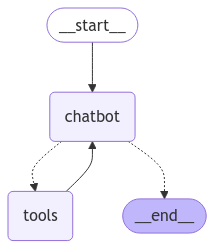

In [57]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [58]:
# 我們要設定一個 thread_id 來讓 graph 記住每個對話的狀態

config = {"configurable": {"thread_id": "1"}}

In [59]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello, Will! How can I assist you today?


In [60]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name, Will! How can I help you today?


接著我們把 thread 給換掉，看看是否能夠獲取我的記憶。

In [61]:
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I don't have the ability to remember past interactions or personal details, including names. However, I'm here to help you with any questions or topics you'd like to discuss!


In [63]:
config = {"configurable": {"thread_id": "1"}}

snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='5f89a561-42ca-428e-b3ee-cf430d58bfef'), AIMessage(content='Hello, Will! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 87, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'stop', 'logprobs': None}, id='run-7be44b84-92e2-40b6-820c-cac1eb69b00b-0', usage_metadata={'input_tokens': 87, 'output_tokens': 12, 'total_tokens': 99, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Remember my name?', additional_kwargs={

In [66]:
# 調換不同記憶
config = {"configurable": {"thread_id": "2"}}

snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='ad97d098-f940-4d23-a137-b512cebf3fb3'), AIMessage(content="I don't have the ability to remember past interactions or personal details, including names. However, I'm here to help you with any questions or topics you'd like to discuss!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 83, 'total_tokens': 117, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'stop', 'logprobs': None}, id='run-5780f3b1-d343-40fe-968f-788ca7be3908-0', usage_metadata={'input_tokens': 83, 'output_tokens': 34, 'total_tokens': 117, 'input_token_details': {'audio': 0, 'cache_r

### Part 4: Human-in-the-loop¶


顧名思義，就是我們想要在過程中，加入人類的確認，可能是檢查或是進行狀態的修改。

In [67]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])  # 這裡使用了 ToolNode 來取代之前的 BasicToolNode

graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,  # 這裡使用了 tools_condition 來取代之前的 route_tools
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")

In [69]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=[
        "tools"
    ],  # 新增 interrupt_before ，再看到 tools 時先不要執行，停下來讓人類進行回饋。也可以是 interrupt_after=["tools"]
)

In [70]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_1Ggn2fhSomBTf1AYpstpzd2W)
 Call ID: call_1Ggn2fhSomBTf1AYpstpzd2W
  Args:
    query: LangGraph


In [ ]:
# 我們來看看目前 graph 運作到哪一步（哪一個狀態）

snapshot = graph.get_state(config)
print(f"Current state: {snapshot.values['messages'][-1]}")
print(f"Next state: {snapshot.next}")

# 沒錯，我們可以看到下一個狀態是 tools

Current state: content='' additional_kwargs={'tool_calls': [{'id': 'call_1Ggn2fhSomBTf1AYpstpzd2W', 'function': {'arguments': '{"query":"LangGraph"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 94, 'total_tokens': 113, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-5917bc1b-aa62-4848-953f-a71b3115d7e4-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': 'call_1Ggn2fhSomBTf1AYpstpzd2W', 'type': 'tool_call'}] usage_metadata={'input_tokens': 94, 'output_tokens': 19, 'total_tokens': 113, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_tok

In [83]:
# 要如何從剛剛的起點重新開始呢？
# 我們可以使用 `None` 重入剛剛的 graph，讓它繼續執行

# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

Here are some resources and key information about LangGraph:

1. **Overview of LangGraph**:
   - LangGraph is a library in the LangChain ecosystem designed to simplify the development of complex, multi-agent large language model (LLM) applications. It facilitates the creation of stateful, flexible, and scalable systems through a structure of nodes, edges, and state management.
   - [Read more here](https://www.datacamp.com/tutorial/langgraph-tutorial).

2. **Features**:
   - It is a low-level framework that enables developers to create stateful, multi-actor applications with LLMs.
   - It supports features such as cycles, controllability, and persistence, making it suitable for building sophisticated agent and multi-agent workflows.
   - [Learn more about its features](https://langchain-ai.github.io/langgraph/).

These resources will provide you with a solid foundation to start learning about LangGraph an

### Part 5: Manually Updating the State

剛剛只是打斷，如果說真的要改一些東西呢？

In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

#### Define the state schema ####


class State(TypedDict):
    messages: Annotated[list, add_messages]


# We annotated messages with the pre-built add_messages function.
# This instructs the graph to always append values to the existing list,
# rather than overwriting the list directly. The same logic is applied here,
# so the messages we passed to update_state were appended in the same way!


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])  # 這裡使用了 ToolNode 來取代之前的 BasicToolNode

graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,  # 這裡使用了 tools_condition 來取代之前的 route_tools
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt **after** actions, if desired.
    # interrupt_after=["tools"]
)

user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [86]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_rhVmwhBNHjAywmC0PGFsIdia)
 Call ID: call_rhVmwhBNHjAywmC0PGFsIdia
  Args:
    query: LangGraph


下一個階段，LLM 就準備要呼叫搜尋引擎了！
可是我們的問題並不需要搜尋引擎，我們要如何中途手動修改狀態呢？

我們直接將答案丟給 LLM，並且跳過搜尋引擎的過程。

In [89]:
from langchain_core.messages import AIMessage, ToolMessage

answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)
new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(
        content=answer, tool_call_id=existing_message.tool_calls[0]["id"]
    ),  # 模擬 tool 的回應
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),  # 模擬 LLM 的回應
]

new_messages[-1].pretty_print()

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


In [91]:
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot",  # 就很像是我們要假裝我們是 graph 中的某個 node 一樣，我們在這裡假裝我們是 chatbot 的意思
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])



Last 2 messages;
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='b8739dbf-7f0e-4754-a35c-3aeebfab75e5', tool_call_id='call_rhVmwhBNHjAywmC0PGFsIdia'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={}, id='52737050-67df-4b12-98e0-42ce3a855216')]


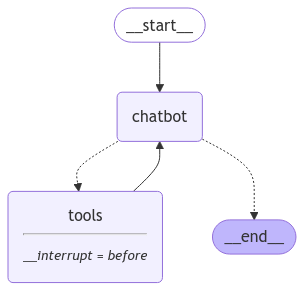

In [92]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

如果說，我們想要覆寫的只是已經存在的 message 呢？

In [ ]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

https://ithelp.ithome.com.tw/m/articles/10347050

https://r23456999.medium.com/langgraph-%E8%88%87-langfuse-%E6%89%93%E9%80%A0%E6%99%BA%E8%83%BD%E8%A7%80%E6%B8%AC%E7%B3%BB%E7%B5%B1%E7%9A%84%E5%AE%8C%E7%BE%8E%E7%B5%84%E5%90%88-da09e515cf1d